# 项目：使用隐马尔可夫模型进行词性标注 
---
### 简介

词性标注是指根据周围语境中的单词判断某个单词句法类别的流程。通常用于消除自然语言短语的歧义，因为它可以快速完成，并且准确率高。词性标注可以用于很多自然语言处理任务，例如在语音合成中确定正确的发音（例如 _dis_-count 是名词，而 dis-_count_ 是动词），以便检索信息和区分单词含义。

在此 notebook 中，你将使用 [Pomegranate](http://pomegranate.readthedocs.io/) 库构建词性标注隐马尔可夫模型，并使用“通用”标签集。[在使用更大型的标签集对实际文本语料库进行标注时，隐马尔可夫模型的准确率达到了 96% 以上](http://www.coli.uni-saarland.de/~thorsten/publications/Brants-ANLP00.pdf)。隐马尔可夫模型还用于语音识别和语音生成、机器翻译、生物信息学基因识别和计算机视觉人类手势识别，等等。

![](_post-hmm.png)

该 notebook 已经包含一些帮助你着手编程的代码。要完成此项目，你只需在有标记的地方添加一些新的功能；除此之外，不需要修改所提供的代码。标题中以**实现**开头的部分表明你必须在下面的代码块中提供代码。我们会在每个部分提供说明，并在以 'TODO' 语句开头的代码块中提供实现细节。请务必仔细阅读说明！

<div class="alert alert-block alert-info">
**注意：**完成所有代码实现后，最后需要将 iPython Notebook 导出为 HTML 文档。在将 notebook 导出为 HTML 前，请运行所有代码单元格，以便审阅专家能够查看最终实现和输出结果。然后**导出 notebook**，方法是：运行 notebook 中的最后一个单元格，或使用顶部的菜单并依次转到**文件 -> 下载为 -> HTML (.html)**。提交内容应该同时包含 `html` 和 `ipynb` 文件。
</div>

<div class="alert alert-block alert-info">
**注意：**可以通过 `Shift + Enter` 键盘快捷键执行代码和标记单元格，也可以通过双击单元格进入编辑模式，编辑标记单元格。
</div>

### 后续步骤
要通过该项目，你必须完成下面的第 1-3 步。第 4 步包含参考资料，帮助你进一步研究 HMM 标签器。

- [第 1 步](#Step-1:-Read-and-preprocess-the-dataset)：查看提供的界面，以加载并访问文本语料库
- [第 2 步](#Step-2:-Build-a-Most-Frequent-Class-tagger)： 构建最常见类别标签器并用作基准
- [第 3 步](#Step-3:-Build-an-HMM-tagger)： 构建 HMM 词性标签器并与 MFC 基准进行比较
- [第 4 步](#Step-4:-[Optional]-Improving-model-performance)：（可选）改进 HMM 标签器

<div class="alert alert-block alert-warning">
**注意：** 确保在 Workspace 中选择 **Python 3** 内核，如果你是在自己的机子上运行 Jupyter 服务器，则选择 hmm-tagger conda 环境。
</div>

In [1]:
# Jupyter "magic methods" -- only need to be run once per kernel restart
%load_ext autoreload
%aimport helpers, tests
%autoreload 1

In [2]:
# import python modules -- this cell needs to be run again if you make changes to any of the files
import matplotlib.pyplot as plt
import numpy as np

from IPython.core.display import HTML
from itertools import chain
from collections import Counter, defaultdict
from helpers import show_model, Dataset
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution

## 第 1 步：读取并预处理数据集
---
我们首先将读取文本语料库并将其划分为训练数据集和测试数据集。该数据集是 [Brown 语料库](https://en.wikipedia.org/wiki/Brown_Corpus)（来源于 [NLTK](https://www.nltk.org/) 库）的一个副本，已经过预处理，只包含[通用标签集](https://arxiv.org/pdf/1104.2086.pdf)。与更大的标签集（例如完整的[宾州树库标签集](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)）相比，同一模型在此简化标签集上的准确率应该稍微高些，但是遵循的流程是一样的。

在 helpers.py 中提供的  `Dataset` 类将读取并解析语料库。你可以按以下格式编写，生成自己的与读取器兼容的数据集。该数据集存储在纯文本文件中，包含一系列单词和相应的标签。每个句子都在第一行以唯一标识符开始，然后在接下来的每一行都是一个按标签划分的单词/标签对。句子用一个空白行分隔。

来自 Brown 语料库的示例。

```
b100-38532
Perhaps	ADV
it	PRON
was	VERB
right	ADJ
;	.
;	.

b100-35577
...
```

In [3]:
data = Dataset("tags-universal.txt", "brown-universal.txt", train_test_split=0.8)

print("There are {} sentences in the corpus.".format(len(data)))
print("There are {} sentences in the training set.".format(len(data.training_set)))
print("There are {} sentences in the testing set.".format(len(data.testing_set)))

assert len(data) == len(data.training_set) + len(data.testing_set), \
       "The number of sentences in the training set + testing set should sum to the number of sentences in the corpus"

There are 57340 sentences in the corpus.
There are 45872 sentences in the training set.
There are 11468 sentences in the testing set.


### 数据集接口

你可以通过由 `Dataset` 类提供的简单接口访问数据集的（大多数）不可变引用，该接口表示可迭代的句子集合，并且可以轻松划分数据以进行训练和测试。请查看下面的参考资料，然后运行并查看下面的几个单元格，确保理解该接口，然后再继续下一步。

```
Dataset-only Attributes:
    training_set - reference to a Subset object containing the samples for training
    testing_set - reference to a Subset object containing the samples for testing

Dataset & Subset Attributes:
    sentences - a dictionary with an entry {sentence_key: Sentence()} for each sentence in the corpus
    keys - an immutable ordered (not sorted) collection of the sentence_keys for the corpus
    vocab - an immutable collection of the unique words in the corpus
    tagset - an immutable collection of the unique tags in the corpus
    X - returns an array of words grouped by sentences ((w11, w12, w13, ...), (w21, w22, w23, ...), ...)
    Y - returns an array of tags grouped by sentences ((t11, t12, t13, ...), (t21, t22, t23, ...), ...)
    N - returns the number of distinct samples (individual words or tags) in the dataset

Methods:
    stream() - returns an flat iterable over all (word, tag) pairs across all sentences in the corpus
    __iter__() - returns an iterable over the data as (sentence_key, Sentence()) pairs
    __len__() - returns the nubmer of sentences in the dataset
```

例如，对于句子 `{"s0": Sentence(("See", "Spot", "run"), ("VERB", "NOUN", "VERB")), "s1": Sentence(("Spot", "ran"), ("NOUN", "VERB"))}` 的子集 `subset`，该子集将具有以下属性：

```
subset.keys == {"s1", "s0"}  # unordered
subset.vocab == {"See", "run", "ran", "Spot"}  # unordered
subset.tagset == {"VERB", "NOUN"}  # unordered
subset.X == (("Spot", "ran"), ("See", "Spot", "run"))  # order matches .keys
subset.Y == (("NOUN", "VERB"), ("VERB", "NOUN", "VERB"))  # order matches .keys
subset.N == 7  # there are a total of seven observations over all sentences
len(subset) == 2  # because there are two sentences
```

<div class="alert alert-block alert-info">
**注意：** `Dataset` 类_很便利_，但是**不**高效。不适合巨大的数据集，因为它存储了相同数据的很多多余副本。
</div>

#### 句子

`Dataset.sentences` 是训练语料库中的所有句子的字典，每个句子的键都是唯一句子标识符。每个 `Sentence` 本身是一个对象，具有两个属性：一个由句子中的单词组成的元组，称为 `words`，以及一个由每个单词对应的标签组成的元组，称为 `tags`。

In [4]:
key = 'b100-38532'
print("Sentence: {}".format(key))
print("words:\n\t{!s}".format(data.sentences[key].words))
print("tags:\n\t{!s}".format(data.sentences[key].tags))

Sentence: b100-38532
words:
	('Perhaps', 'it', 'was', 'right', ';', ';')
tags:
	('ADV', 'PRON', 'VERB', 'ADJ', '.', '.')


<div class="alert alert-block alert-info">
**注意：**底层可迭代序列是语料库中的**无序**句子；每次调用时，不能保证会按照相同的顺序返回句子。如果你需要按照一定的顺序访问数据，请使用 `Dataset.stream()`、`Dataset.keys`、`Dataset.X` 或 `Dataset.Y` 属性。
</div>

#### 计算唯一元素的数量

你可以通过 `Dataset.vocab` 访问唯一单词列表（数据集词汇表）和 `Dataset.tagset` 访问唯一标签列表。

In [5]:
print("There are a total of {} samples of {} unique words in the corpus."
      .format(data.N, len(data.vocab)))
print("There are {} samples of {} unique words in the training set."
      .format(data.training_set.N, len(data.training_set.vocab)))
print("There are {} samples of {} unique words in the testing set."
      .format(data.testing_set.N, len(data.testing_set.vocab)))
print("There are {} words in the test set that are missing in the training set."
      .format(len(data.testing_set.vocab - data.training_set.vocab)))

assert data.N == data.training_set.N + data.testing_set.N, \
       "The number of training + test samples should sum to the total number of samples"

There are a total of 1161192 samples of 56057 unique words in the corpus.
There are 928458 samples of 50536 unique words in the training set.
There are 232734 samples of 25112 unique words in the testing set.
There are 5521 words in the test set that are missing in the training set.


#### 访问单词和标签序列
通过 `Dataset.X` 和 `Dataset.Y` 属性可以访问数据集中每个句子的有序匹配单词和标签序列集合。

In [6]:
# accessing words with Dataset.X and tags with Dataset.Y 
for i in range(2):    
    print("Sentence {}:".format(i + 1), data.X[i])
    print()
    print("Labels {}:".format(i + 1), data.Y[i])
    print()

Sentence 1: ('Mr.', 'Podger', 'had', 'thanked', 'him', 'gravely', ',', 'and', 'now', 'he', 'made', 'use', 'of', 'the', 'advice', '.')

Labels 1: ('NOUN', 'NOUN', 'VERB', 'VERB', 'PRON', 'ADV', '.', 'CONJ', 'ADV', 'PRON', 'VERB', 'NOUN', 'ADP', 'DET', 'NOUN', '.')

Sentence 2: ('But', 'there', 'seemed', 'to', 'be', 'some', 'difference', 'of', 'opinion', 'as', 'to', 'how', 'far', 'the', 'board', 'should', 'go', ',', 'and', 'whose', 'advice', 'it', 'should', 'follow', '.')

Labels 2: ('CONJ', 'PRT', 'VERB', 'PRT', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'ADP', 'ADV', 'ADV', 'DET', 'NOUN', 'VERB', 'VERB', '.', 'CONJ', 'DET', 'NOUN', 'PRON', 'VERB', 'VERB', '.')



#### 访问（单词、标签）示例 
`Dataset.stream()` 方法会返回一个迭代器，它会将整个语料库中的所有句子的每对单词-标签连结到一起。

In [7]:
# use Dataset.stream() (word, tag) samples for the entire corpus
print("\nStream (word, tag) pairs:\n")
for i, pair in enumerate(data.stream()):
    print("\t", pair)
    if i > 5: break


Stream (word, tag) pairs:

	 ('Mr.', 'NOUN')
	 ('Podger', 'NOUN')
	 ('had', 'VERB')
	 ('thanked', 'VERB')
	 ('him', 'PRON')
	 ('gravely', 'ADV')
	 (',', '.')


对于我们的基准标签器和我们将构建的 HMM 模型，我们需要根据训练语料库中的观察量频次估算标签和单词的频次。在下面的几个单元格中，你将完成计算多个计数集合的函数。  

## 第 2 步：构建最常见类别标签器
---

或许最简单的标签器（以及良好的标签器性能基准）是直接选择分配给每个单词频次最高的标签。这个“最常见类别”标签器会检查在序列中观察的每个单词，并为其分配在语料库中最常分配给该单词的标签。

### 实现：成对计数

请完成下面的函数，该函数会计算两个输入序列的联合频次。

In [8]:
def pair_counts(sequences_A, sequences_B):
    """Return a dictionary keyed to each unique value in the first sequence list
    that counts the number of occurrences of the corresponding value from the
    second sequences list.
    
    For example, if sequences_A is tags and sequences_B is the corresponding
    words, then if 1244 sequences contain the word "time" tagged as a NOUN, then
    you should return a dictionary such that pair_counts[NOUN][time] == 1244
    """
    assert len(sequences_A) == len(sequences_B), "two sequences' length must be equal"
    count_dic = defaultdict(lambda:defaultdict(int))
    seq_length = len(sequences_A)
    for i in range(seq_length):
        key1 = sequences_A[i]
        key2 = sequences_B[i]
        count_dic[key1][key2] += 1
        
    return count_dic

# Calculate C(t_i, w_i)
sequence_tags = list(chain(*data.training_set.Y))
sequence_words = list(chain(*data.training_set.X))
emission_counts = pair_counts(sequence_tags, sequence_words)

assert len(emission_counts) == 12, \
       "Uh oh. There should be 12 tags in your dictionary."
assert max(emission_counts["NOUN"], key=emission_counts["NOUN"].get) == 'time', \
       "Hmmm...'time' is expected to be the most common NOUN."
HTML('<div class="alert alert-block alert-success">Your emission counts look good!</div>')

### 实现：最常见类别标签器

使用 `pair_counts()` 函数和训练数据集找到训练数据中每个单词的最常见类别标签，并填充下面的 `mfc_table`。表格键应该是单词，值应该是相应的标签字符串 。

`MFCTagger` 类用来模仿 Pomegranite HMM 模型的接口，使它们可以交替地使用。

In [9]:
# Create a lookup table mfc_table where mfc_table[word] contains the tag label most frequently assigned to that word
from collections import namedtuple

FakeState = namedtuple("FakeState", "name")

class MFCTagger:
    # NOTE: You should not need to modify this class or any of its methods
    missing = FakeState(name="<MISSING>")
    
    def __init__(self, table):
        self.table = defaultdict(lambda: MFCTagger.missing)
        self.table.update({word: FakeState(name=tag) for word, tag in table.items()})
        
    def viterbi(self, seq):
        """This method simplifies predictions by matching the Pomegranate viterbi() interface"""
        return 0., list(enumerate(["<start>"] + [self.table[w] for w in seq] + ["<end>"]))


# TODO: calculate the frequency of each tag being assigned to each word (hint: similar, but not
# the same as the emission probabilities) and use it to fill the mfc_table
sequence_tags = list(chain(*data.training_set.Y))
sequence_words = list(chain(*data.training_set.X))
word_counts = pair_counts(sequence_words, sequence_tags)

mfc_table = {word: max(word_counts[word], key=word_counts[word].get) for word in word_counts.keys()}

# DO NOT MODIFY BELOW THIS LINE
mfc_model = MFCTagger(mfc_table) # Create a Most Frequent Class tagger instance

assert len(mfc_table) == len(data.training_set.vocab), ""
assert all(k in data.training_set.vocab for k in mfc_table.keys()), ""
assert sum(int(k not in mfc_table) for k in data.testing_set.vocab) == 5521, ""
HTML('<div class="alert alert-block alert-success">Your MFC tagger has all the correct words!</div>')

### 使用模型做出预测
下面提供的辅助函数会与 Pomegranate 网络模型和模仿的 MFCTagger 交互，以通过简单的序列解码函数利用 Pomegranate 中的[缺失值](http://pomegranate.readthedocs.io/en/latest/nan.html)功能。请运行这些函数，然后运行下个单元格，看看 MFC 标签器做出的一些预测。

In [10]:
def replace_unknown(sequence):
    """Return a copy of the input sequence where each unknown word is replaced
    by the literal string value 'nan'. Pomegranate will ignore these values
    during computation.
    """
    return [w if w in data.training_set.vocab else 'nan' for w in sequence]

def simplify_decoding(X, model):
    """X should be a 1-D sequence of observations for the model to predict"""
    _, state_path = model.viterbi(replace_unknown(X))
    return [state[1].name for state in state_path[1:-1]]  # do not show the start/end state predictions

### 使用 MFC 标签器进行解码的示例序列

In [11]:
for key in data.testing_set.keys[:3]:
    print("Sentence Key: {}\n".format(key))
    print("Predicted labels:\n-----------------")
    print(simplify_decoding(data.sentences[key].words, mfc_model))
    print()
    print("Actual labels:\n--------------")
    print(data.sentences[key].tags)
    print("\n")

Sentence Key: b100-28144

Predicted labels:
-----------------
['CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.']

Actual labels:
--------------
('CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.')


Sentence Key: b100-23146

Predicted labels:
-----------------
['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.']

Actual labels:
--------------
('PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.')


Sentence Key: b100-35462

Predicted labels:
-----------------
['DET', 'ADJ', 'NOUN', 'VERB', 'VERB', 'VERB', 'ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', '.', 'ADP', 'ADJ', 'NOUN', '.', 'CONJ', 'ADP', 'DET', '<MISSING>', 'ADP', 'ADJ', 'ADJ', 

### 评估模型准确率

以下函数将评估 MFC 标签器在文本语料库中的所有句子集合上的准确率。

In [12]:
def accuracy(X, Y, model):
    """Calculate the prediction accuracy by using the model to decode each sequence
    in the input X and comparing the prediction with the true labels in Y.
    
    The X should be an array whose first dimension is the number of sentences to test,
    and each element of the array should be an iterable of the words in the sequence.
    The arrays X and Y should have the exact same shape.
    
    X = [("See", "Spot", "run"), ("Run", "Spot", "run", "fast"), ...]
    Y = [(), (), ...]
    """
    correct = total_predictions = 0
    for observations, actual_tags in zip(X, Y):
        
        # The model.viterbi call in simplify_decoding will return None if the HMM
        # raises an error (for example, if a test sentence contains a word that
        # is out of vocabulary for the training set). Any exception counts the
        # full sentence as an error (which makes this a conservative estimate).
        try:
            most_likely_tags = simplify_decoding(observations, model)
            correct += sum(p == t for p, t in zip(most_likely_tags, actual_tags))
        except:
            pass
        total_predictions += len(observations)
    return correct / total_predictions

#### 评估 MFC 标签器的准确率
运行下个单元格，以评估标签器在训练语料库和测试语料库上的准确率。

In [13]:
mfc_training_acc = accuracy(data.training_set.X, data.training_set.Y, mfc_model)
print("training accuracy mfc_model: {:.2f}%".format(100 * mfc_training_acc))

mfc_testing_acc = accuracy(data.testing_set.X, data.testing_set.Y, mfc_model)
print("testing accuracy mfc_model: {:.2f}%".format(100 * mfc_testing_acc))

assert mfc_training_acc >= 0.955, "Uh oh. Your MFC accuracy on the training set doesn't look right."
assert mfc_testing_acc >= 0.925, "Uh oh. Your MFC accuracy on the testing set doesn't look right."
HTML('<div class="alert alert-block alert-success">Your MFC tagger accuracy looks correct!</div>')

training accuracy mfc_model: 95.72%
testing accuracy mfc_model: 93.01%


## 第 3 步：构建 HMM 标签器
---
HMM 标签器对每个可能的标签都有一个隐藏状态，并用两个分布参数化：发射概率，表示从每个隐藏状态观察到给定**单词**的条件概率；以及转移概率， 表示在序列中的**标签**之间移动的条件概率。

我们还将估计起始概率分布（每个**标签**是序列中的第一个标签的概率），以及结束概率分布（ 每个**标签**是序列中的最后一个标签的概率）。

你可以根据以下部分所述的频次计算这些分布的最大似然率估计值，你将在这些部分实现计算频次的函数，并最终构建模型。HMM 模型将根据以下公式做出预测：

$$t_i^n = \underset{t_i^n}{\mathrm{argmax}} \prod_{i=1}^n P(w_i|t_i) P(t_i|t_{i-1})$$

详情请参阅语音和语言处理[第 10 章](https://web.stanford.edu/~jurafsky/slp3/10.pdf)。

### 实现：一元模型计数

请完成以下函数，以估算每个符号与所有输入序列的同现频率。HMM 模型中的一元概率是根据以下公式估算的，其中 N 是输入中的总样本数。（你暂时只需计算数量。）

$$P(tag_1) = \frac{C(tag_1)}{N}$$

In [14]:
def unigram_counts(sequences):
    """Return a dictionary keyed to each unique value in the input sequence list that
    counts the number of occurrences of the value in the sequences list. The sequences
    collection should be a 2-dimensional array.
    
    For example, if the tag NOUN appears 275558 times over all the input sequences,
    then you should return a dictionary such that your_unigram_counts[NOUN] == 275558.
    """
    tag_dict = defaultdict(int)
    for tags in sequences:
        for tag in tags:
            tag_dict[tag] += 1
    return tag_dict

# TODO: call unigram_counts with a list of tag sequences from the training set
tag_unigrams = unigram_counts(data.training_set.Y)

assert set(tag_unigrams.keys()) == data.training_set.tagset, \
       "Uh oh. It looks like your tag counts doesn't include all the tags!"
assert min(tag_unigrams, key=tag_unigrams.get) == 'X', \
       "Hmmm...'X' is expected to be the least common class"
assert max(tag_unigrams, key=tag_unigrams.get) == 'NOUN', \
       "Hmmm...'NOUN' is expected to be the most common class"
HTML('<div class="alert alert-block alert-success">Your tag unigrams look good!</div>')

### 实现：二元计数

请完成以下函数，以估算每个输入序列中每对符号的同现频率。这些计数会在 HMM 模型中用于估算频次计数中两个标签的二元概率，公式如下：$$P(tag_2|tag_1) = \frac{C(tag_2|tag_1)}{C(tag_2)}$$

In [15]:
def bigram_counts(sequences):
    """Return a dictionary keyed to each unique PAIR of values in the input sequences
    list that counts the number of occurrences of pair in the sequences list. The input
    should be a 2-dimensional array.
    
    For example, if the pair of tags (NOUN, VERB) appear 61582 times, then you should
    return a dictionary such that your_bigram_counts[(NOUN, VERB)] == 61582
    """
    tag_dict = defaultdict(int)
    for tags in sequences:
        for i in range (len(tags)-1):
            tag_dict[(tags[i], tags[i+1])] += 1
        
    return tag_dict

tag_bigrams = bigram_counts(data.training_set.Y)

assert len(tag_bigrams) == 144, \
       "Uh oh. There should be 144 pairs of bigrams (12 tags x 12 tags)"
assert min(tag_bigrams, key=tag_bigrams.get) in [('X', 'NUM'), ('PRON', 'X')], \
       "Hmmm...The least common bigram should be one of ('X', 'NUM') or ('PRON', 'X')."
assert max(tag_bigrams, key=tag_bigrams.get) in [('DET', 'NOUN')], \
       "Hmmm...('DET', 'NOUN') is expected to be the most common bigram."
HTML('<div class="alert alert-block alert-success">Your tag bigrams look good!</div>')

### 实现：序列起始计数
请完成以下代码，以估算以每个标签开始的序列二元概率。

In [16]:
def starting_counts(sequences):
    """Return a dictionary keyed to each unique value in the input sequences list
    that counts the number of occurrences where that value is at the beginning of
    a sequence.
    
    For example, if 8093 sequences start with NOUN, then you should return a
    dictionary such that your_starting_counts[NOUN] == 8093
    """
    tag_starts = defaultdict(int)
    for tags in sequences:
        tag_starts[tags[0]] += 1
    return tag_starts

tag_starts = starting_counts(data.training_set.Y)

assert len(tag_starts) == 12, "Uh oh. There should be 12 tags in your dictionary."
assert min(tag_starts, key=tag_starts.get) == 'X', "Hmmm...'X' is expected to be the least common starting bigram."
assert max(tag_starts, key=tag_starts.get) == 'DET', "Hmmm...'DET' is expected to be the most common starting bigram."
HTML('<div class="alert alert-block alert-success">Your starting tag counts look good!</div>')

### 实现：序列结束计数
请完成以下代码，以估算以每个标签结束的序列二元概率。

In [17]:
def ending_counts(sequences):
    """Return a dictionary keyed to each unique value in the input sequences list
    that counts the number of occurrences where that value is at the end of
    a sequence.
    
    For example, if 18 sequences end with DET, then you should return a
    dictionary such that your_starting_counts[DET] == 18
    """
    end_starts = defaultdict(int)
    for tags in sequences:
        end_starts[tags[-1]] += 1
    return end_starts


tag_ends = ending_counts(data.training_set.Y)

assert len(tag_ends) == 12, "Uh oh. There should be 12 tags in your dictionary."
assert min(tag_ends, key=tag_ends.get) in ['X', 'CONJ'], "Hmmm...'X' or 'CONJ' should be the least common ending bigram."
assert max(tag_ends, key=tag_ends.get) == '.', "Hmmm...'.' is expected to be the most common ending bigram."
HTML('<div class="alert alert-block alert-success">Your ending tag counts look good!</div>')

### 实现：基本 HMM 标签器
使用在上面计算的一元和二元概率构建一个隐马尔可夫标签器。

- 每个标签添加一个状态
    - 应使用以下公式估算每个状态的发射概率：$P(w|t) = \frac{C(t, w)}{C(t)}$
- 添加一条从起始状态 `basic_model.start` 到每个标签的边
    - 应使用以下公式估算转移概率：$P(t|start) = \frac{C(start, t)}{C(start)}$
- 添加一条从每个标签到结束状态 `basic_model.end` 的边
    - 应使用以下公式估算转移概率：$P(end|t) = \frac{C(t, end)}{C(t)}$
- 在每对标签之间添加一条边
    - 应使用以下公式估算转移概率：$P(t_2|t_1) = \frac{C(t_1, t_2)}{C(t_1)}$

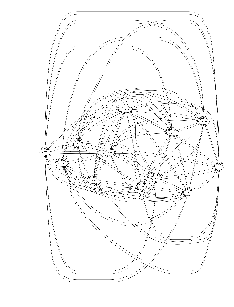

In [22]:
#注意：pomegranate版本太低可能导致项目通不过，在0.7.3上会报错:ValueError: Symbol 'nan' is not defined in a distribution
basic_model = HiddenMarkovModel(name="base-hmm-tagger")

# TODO: create states with emission probability distributions P(word | tag) and add to the model
# (Hint: you may need to loop & create/add new states)
states={}
for tag in data.tagset:
    word_counts = emission_counts[tag]
    total_counts = sum( count for word,count in word_counts.items())
    probabilities = {word:count/total_counts  for word, count in word_counts.items()}
    emissions = DiscreteDistribution(probabilities)
    state = State(emissions, name=tag)
    states[tag] = state
basic_model.add_states(list(states.values()))

# TODO: add edges between states for the observed transition frequencies P(tag_i | tag_i-1)
# (Hint: you may need to loop & add transitions)
c_start = len(data.training_set)
for tag, count in tag_starts.items():
    p = count / c_start
    #print('start',tag, p)
    basic_model.add_transition(basic_model.start, states[tag], p)
for tag, count in tag_ends.items():
    c_t = tag_unigrams[tag]
    p = count / c_t
    #print(tag, 'end', p)
    basic_model.add_transition(states[tag], basic_model.end, p)
for tag_pair, count in tag_bigrams.items():
    t1 = tag_pair[0]
    t2 = tag_pair[1]
    c_t1 = tag_unigrams[t1]
    p = count/c_t1
    #print(t1, t2, p)
    basic_model.add_transition(states[t1], states[t2], p)

# NOTE: YOU SHOULD NOT NEED TO MODIFY ANYTHING BELOW THIS LINE
# finalize the model
basic_model.bake()

assert all(tag in set(s.name for s in basic_model.states) for tag in data.training_set.tagset), \
       "Every state in your network should use the name of the associated tag, which must be one of the training set tags."
assert basic_model.edge_count() == 168, \
       ("Your network should have an edge from the start node to each state, one edge between every " +
        "pair of tags (states), and an edge from each state to the end node.")
HTML('<div class="alert alert-block alert-success">Your HMM network topology looks good!</div>')
show_model(basic_model, figsize=(5, 5), filename="HMM.png", overwrite=True, show_ends=False)

In [23]:
hmm_training_acc = accuracy(data.training_set.X, data.training_set.Y, basic_model)
print("training accuracy basic hmm model: {:.2f}%".format(100 * hmm_training_acc))

hmm_testing_acc = accuracy(data.testing_set.X, data.testing_set.Y, basic_model)
print("testing accuracy basic hmm model: {:.2f}%".format(100 * hmm_testing_acc))

assert hmm_training_acc > 0.97, "Uh oh. Your HMM accuracy on the training set doesn't look right."
assert hmm_testing_acc > 0.955, "Uh oh. Your HMM accuracy on the testing set doesn't look right."
HTML('<div class="alert alert-block alert-success">Your HMM tagger accuracy looks correct! Congratulations, you\'ve finished the project.</div>')

training accuracy basic hmm model: 97.54%
testing accuracy basic hmm model: 95.95%


### 利用 HMM 标签器进行解码的示例序列

In [24]:
for key in data.testing_set.keys[:3]:
    print("Sentence Key: {}\n".format(key))
    print("Predicted labels:\n-----------------")
    print(simplify_decoding(data.sentences[key].words, basic_model))
    print()
    print("Actual labels:\n--------------")
    print(data.sentences[key].tags)
    print("\n")

Sentence Key: b100-28144

Predicted labels:
-----------------
['CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.']

Actual labels:
--------------
('CONJ', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'NOUN', 'NUM', '.', 'CONJ', 'NOUN', 'NUM', '.', '.', 'NOUN', '.', '.')


Sentence Key: b100-23146

Predicted labels:
-----------------
['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.']

Actual labels:
--------------
('PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', 'NOUN', 'VERB', 'VERB', '.', 'ADP', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'DET', 'NOUN', '.')


Sentence Key: b100-35462

Predicted labels:
-----------------
['DET', 'ADJ', 'NOUN', 'VERB', 'VERB', 'VERB', 'ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', '.', 'ADP', 'ADJ', 'NOUN', '.', 'CONJ', 'ADP', 'DET', 'NOUN', 'ADP', 'ADJ', 'ADJ', '.', 

## 完成项目
---

<div class="alert alert-block alert-info">
**注意：** **请保存 NOTEBOOK**，然后运行下个单元格以生成 HTML 副本。你需要压缩并提交此文件和 HTML 副本以供审阅。
</div>

In [34]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook HMM Tagger.ipynb to html',
 '[NbConvertApp] Writing 327779 bytes to HMM Tagger.html',
 '[NbConvertApp] Converting notebook HMM Tagger-zh.ipynb to html',
 '[NbConvertApp] Writing 372232 bytes to HMM Tagger-zh.html',
 '[NbConvertApp] Converting notebook HMM warmup (optional).ipynb to html',
 '[NbConvertApp] Writing 309843 bytes to HMM warmup (optional).html',
 '[NbConvertApp] Converting notebook HMM warmup (optional)-zh.ipynb to html',
 '[NbConvertApp] Writing 303931 bytes to HMM warmup (optional)-zh.html']

## 第 4 步：[可选]提高模型性能
---
你可以进一步增强你的标签器，使其在更大的标签集上的表现更好。更大的标签集具有更明显的数据稀疏性问题，因为相同规模的数据用更多的标签划分的话，每个标签的样本量就更少，数据中将有更多频次为零的缺失数据标签。这部分的技巧是可选内容。

- [拉普拉斯平滑法](https://en.wikipedia.org/wiki/Additive_smoothing) (pseudocount)
    拉普拉斯平滑法是指让所有观察到的计数加上一个小的非零值，以抵消未观察到的值。 
- 回退平滑法
    另一种平滑法技巧是在 N 元分布中为缺失值插入值。在处理数据稀疏性问题方面，此方法比拉普拉斯平滑法更高效。详情请参阅[语音和语言处理](https://web.stanford.edu/~jurafsky/slp3/)一书的第 4、9 和 10 章节。
- 扩展为三元分布
    HMM 标签器在此标签集上达到了 96% 以上的准确率，采用的是完整宾州树库标签集和[此](http://www.coli.uni-saarland.de/~thorsten/publications/Brants-ANLP00.pdf)论文中描述的架构。要更改你的 HMM 以达到相同的性能，则需要实现删除插值法（请参见论文），在频率表中添加三元概率，并重新实现维特比算法以考虑三种连续状态，而不是两种。

### 获取具有更大标签集的 Brown 语料库
请运行以下代码，以下载具有完整 NLTK 标签集的 brown 语料库副本。你需要在 NLTK 文档中调查可用的标签集信息，并判断提取要探索的 NLTK 标签子集的最佳方式。如果你按照在第 1 步指定的格式编写以下代码，则可以使用所有上述代码重新加载数据以进行比较。

请参阅 NLTK 图书的[第 5 章](http://www.nltk.org/book/ch05.html)，详细了解可用的标签集。

In [ ]:
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import brown

nltk.download('brown')
training_corpus = nltk.corpus.brown
training_corpus.tagged_sents()[0]